In [1]:
!pip install open_clip_torch
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import T5Tokenizer, T5ForConditionalGeneration
import open_clip
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import torch.nn.functional as nnf
from tqdm import tqdm
from torch.optim import AdamW
import torchvision.transforms as T
from typing import Tuple, Optional, Union
from enum import Enum
import argparse
import PIL

In [3]:
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

In [4]:
txt_nlp_aug = pd.read_csv('/kaggle/input/curated-cxr-report-generation-dataset/NLP_aug_datasets/df_train_aug.csv')
txt_nlp_aug['path'] = txt_nlp_aug['path'].str.replace('../input/curated-cxr-report-generation-dataset', '/kaggle/input/curated-cxr-report-generation-dataset')
test_df = txt_nlp_aug[:5000]

In [5]:
transform = T.Compose([
    T.Resize(size=224, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(size=(224, 224)),
    T.ToTensor(),  # 먼저 Tensor로 변환
    T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
test_df

,id,text,path,aug_text
0,s53865364,"In comparison with the study of ___, there is ...",/kaggle/input/curated-cxr-report-generation-da...,['there is no evidence of pneumothorax with th...
1,s56124320,AP chest compared to ___: PICC line ends in th...,/kaggle/input/curated-cxr-report-generation-da...,['AP chest compared to ___: PICC line ends in ...
2,s50991033,The endotracheal tube tip now lies approximate...,/kaggle/input/curated-cxr-report-generation-da...,['endotracheal tube tip now lies approximately...
3,s50337281,"The cardiac, mediastinal and hilar contours ar...",/kaggle/input/curated-cxr-report-generation-da...,"['cardiac, mediastinal and hilar contours are ..."
4,s51904641,Comparison to ___. No relevant change. Low lun...,/kaggle/input/curated-cxr-report-generation-da...,['no relevant change. Low lung volumes. Modera...
...,...,...,...,...
4995,s57275430,"Compared with ___, there is new opacification ...",/kaggle/input/curated-cxr-report-generation-da...,['vascular plethora in the right upper zone ma...
4996,s57951628,AP radiograph of the chest As compared to prio...,/kaggle/input/curated-cxr-report-generation-da...,['the position of the right chest tube is uncl...
4997,2307,The heart is normal in size. The mediastinum i...,/kaggle/input/curated-cxr-report-generation-da...,['the heart is normal in size. the lungs are h...
4998,s52777228,Comparison is made with prior study ___. Right...,/kaggle/input/curated-cxr-report-generation-da...,['right IJ catheter tip is in the mid SVC in u...


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform, clip_model, t5_model, tokenizer, prefix_length):
        self.df = df
        self.transform = transform
        self.clip_model = clip_model.to(device)
        self.t5_model = t5_model.to(device)
        self.tokenizer = tokenizer
        self.prefix_length = prefix_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx] 
        
        # Load and transform image
        image_path = row['path']
        image = PIL.Image.open(image_path).convert('RGB') 
        image_resize = self.transform(image).unsqueeze(0) 
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        image_resize = image_resize.to(device)

        # prefix
        clip_dim = 512  # CLIP embedding dimension
        t5_hidden_dim = self.t5_model.config.d_model

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_resize).float()

        clip_project = nn.Linear(clip_dim, t5_hidden_dim).to(device)
        prefix = clip_project(image_features)
        
        # text caption
        labels = row['text']
        
        # Tokenize labels / attention mask
        tokenized_labels = self.tokenizer(labels, padding='max_length', 
                                          truncation=True, 
                                          max_length=self.prefix_length, 
                                          return_tensors='pt')
        
        # Get input IDs and attention mask
        captions = tokenized_labels['input_ids'].squeeze(0).to(device)  # Remove batch dimension
        attention_mask = tokenized_labels['attention_mask'].squeeze(0).to(device)  # Remove batch dimension
        
        return prefix, captions, attention_mask

In [8]:
biomedclip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
t5_model=T5ForConditionalGeneration.from_pretrained("t5-small")

# CustomDataset
dataset = CustomDataset(
    df=test_df,
    transform=transform,
    clip_model=biomedclip_model,
    t5_model=t5_model,
    tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False), 
    prefix_length=30
)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [9]:
# codes from github clip-encoder--t5-decoder-
class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MlpTransformer(nn.Module):
    def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
        super().__init__()
        out_d = out_d if out_d is not None else in_dim
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.act = act
        self.fc2 = nn.Linear(h_dim, out_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, 
                mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text =self.t5_model.encoder.embed_tokens(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.t5_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.t5_model(decoder_inputs_embeds=embedding_cat,inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out
    
    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
        self.t5_embedding_size = self.t5_model.encoder.embed_tokens.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.t5_embedding_size * prefix_length) // 2,
                                     self.t5_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.t5_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.t5_model.eval()
        return self


def save_config(args: argparse.Namespace):
    config = {}
    for key, item in args._get_kwargs():
        config[key] = item
    out_path = os.path.join(args.out_dir, f"{args.prefix}.json")
    with open(out_path, 'w') as outfile:
        json.dump(config, outfile)


def load_model(config_path: str, epoch_or_latest: Union[str, int] = '_latest'):
    with open(config_path) as f:
        config = json.load(f)
    parser = argparse.ArgumentParser()
    parser.set_defaults(**config)
    args = parser.parse_args()
    if type(epoch_or_latest) is int:
        epoch_or_latest = f"-{epoch_or_latest:03d}"
    model_path = os.path.join(args.out_dir, f"{args.prefix}{epoch_or_latest}.pt")
    if args.only_prefix:
        model = ClipCaptionPrefix(args.prefix_length)
    else:
        model = ClipCaptionModel(args.prefix_length)
    if os.path.isfile(model_path):
        print(f"loading model from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda'), weights_only=True))
    else:
        print(f"{model_path} is not exist")
    return model, parser


def train(dataset: CustomDataset, model: ClipCaptionModel, args,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device('cuda')
    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    # save_config(args)
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, (tokens, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 250 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest2.pt"),
                )
        progress.close()
        if epoch % args.save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

In [10]:
import torch
from torch.optim import AdamW
import torch.nn as nn

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = ClipCaptionPrefix(prefix_length=10).to(device)  # Move model to GPU
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # To handle padding tokens

# Training parameters
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in data_loader:
        prefixes, captions, attention_masks = batch
        
        # Move input data to the same device as the model (GPU if available)
        prefixes = prefixes.to(device)
        captions = captions.to(device)
        attention_masks = attention_masks.to(device)
        
        # Ensure that captions and prefixes have compatible dimensions
        if captions.size(1) > model.t5_model.config.max_length:  # Check for max length
            captions = captions[:, :model.t5_model.config.max_length]  # Truncate if necessary
        if prefixes.size(1) > model.prefix_length:
            prefixes = prefixes[:, :model.prefix_length]  # Truncate if necessary
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass with labels to compute loss
        outputs = model(tokens=captions, prefix=prefixes, 
                        mask=attention_masks, labels=captions)  

        # Compute the loss
        loss = outputs.loss  # Assuming 'outputs' returns loss directly
        
        # Backward pass
        loss.backward()
        optimizer.step ()
        
        running_loss += loss.item()

    # Print average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader)}")

# Save the model after training
torch.save(model.state_dict(), '/kaggle/working/clip_caption_model.pt')

Epoch [1/10], Loss: 13.093455478643916
Epoch [2/10], Loss: 10.398357275944607
Epoch [3/10], Loss: 8.621296627506329
Epoch [4/10], Loss: 6.9848142308034715
Epoch [5/10], Loss: 6.1253009024699026
Epoch [6/10], Loss: 5.406092431135239
Epoch [7/10], Loss: 4.9974772823843985
Epoch [8/10], Loss: 4.706723908709872
Epoch [9/10], Loss: 4.5535523739590005
Epoch [10/10], Loss: 4.38070245609162


## transformer_inference.ipynb의 beam search쪽 코드 추가한 코드

In [11]:
def generate_beam(t5_model, clip_model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    t5_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    stop_token_index = tokenizer.encode(stop_token, return_tensors="pt").to(device)

    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)

    # Prompt encoding
    if prompt:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        encoder_outputs = t5_model.encoder(input_ids=input_ids).last_hidden_state
    elif embed is not None:
        # Use the embedding directly if provided (from ClipCaptionPrefix)
        encoder_outputs = embed.to(device)
    else:
        raise ValueError("Either a prompt or embed must be provided.")

    # Initialize decoder inputs with the start token
    decoder_input_ids = torch.tensor([[t5_model.config.decoder_start_token_id]] * beam_size, device=device)

    # Initialize beam search variables
    scores = None
    seq_lengths = torch.zeros(beam_size, device=device)  # Initialize sequence lengths
    is_stopped = torch.zeros(beam_size, dtype=torch.bool, device=device)  # Track stopped sequences

    for i in range(entry_length):
        with torch.no_grad():
            # t5_model.forward
            outputs = t5_model(
                encoder_outputs=encoder_outputs.repeat(beam_size, 1, 1),
                decoder_input_ids=decoder_input_ids,
                return_dict=True
            )

            logits = outputs.logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(dim=-1).log()

            if scores is None:
                scores, next_tokens = logits.topk(beam_size, dim=-1)
                scores, next_tokens = scores.squeeze(0), next_tokens.squeeze(0)
                seq_lengths[~is_stopped] += 1
                decoder_input_ids = torch.cat([decoder_input_ids, next_tokens.unsqueeze(1)], dim=-1)
            else:
                logits[is_stopped] = -float('inf')
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                scores_sum_avg = scores_sum / seq_lengths[:, None]
                scores_sum_avg, next_tokens = scores_sum_avg.view(-1).topk(beam_size, -1)

                # Update beam source indices
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]

                # Update decoder input ids and scores
                decoder_input_ids = decoder_input_ids[next_tokens_source]
                decoder_input_ids = torch.cat([decoder_input_ids, next_tokens.unsqueeze(1)], dim=-1)
                scores = scores_sum_avg * seq_lengths
                is_stopped = is_stopped[next_tokens_source]

            # Check for stop token and update stopped beams
            is_stopped = is_stopped | next_tokens.eq(t5_model.config.eos_token_id)
            if is_stopped.all():
                break

    scores = scores / seq_lengths
    output_list = decoder_input_ids.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)], skip_special_tokens=True) 
                    for output, length in zip(output_list, seq_lengths)]
    
    # Sort by final scores
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    
    return output_texts

In [12]:
prefix_length = 10
model = ClipCaptionPrefix(prefix_length)
model.load_state_dict(torch.load('clip_caption_model.pt', map_location='cpu'))

model = model.eval() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/tmp/ipykernel_30/2258756706.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('clip_caption_model.pt', map_location='cpu'))


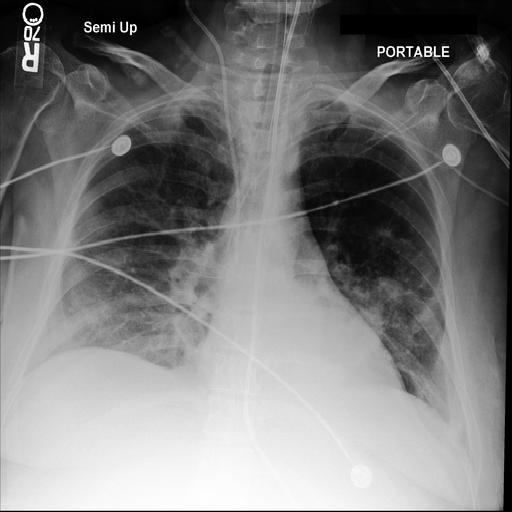

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
image_path = '/kaggle/input/curated-cxr-report-generation-dataset/mimic_dset/re_512_3ch/Valid/s50001612.jpg'
pil_image = PIL.Image.open(image_path).convert('RGB')
display(pil_image)

# 이미지 불러오고 prefix 생성
image = transform(pil_image).unsqueeze(0).to(device)

# 위에 코드 그대로
clip_dim = 512  
t5_hidden_dim = t5_model.config.d_model

with torch.no_grad():
    image_features = biomedclip_model.encode_image(image).float()

clip_project = nn.Linear(clip_dim, t5_hidden_dim).to(device)  
prefix_embed = clip_project(image_features)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False)

# Beam search 텍스트 생성
generated_texts = generate_beam(
    t5_model=t5_model,
    clip_model=biomedclip_model,
    tokenizer=t5_tokenizer,
    prompt='Generate Radiology report of this CXR',
    embed=prefix_embed
)

# 결과 출력
print('\nGenerated Texts:')
for text in generated_texts:
    print(text)


## 또는 beam search를 쓰지 않은 텍스트 생성에는 이 코드 적용

In [14]:
# 모델을 로드하는 함수
def load_model(model_path: str, prefix_length: int):
    model = ClipCaptionPrefix(prefix_length=prefix_length)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()  # 평가 모드로 설정
    return model

# 이미지 캡션 생성 함수
def generate_caption(image_path: str, clip_model, t5_model, tokenizer, device: torch.device, max_length=50):
    # 이미지를 열고 전처리합니다.
    image = PIL.Image.open(image_path).convert('RGB') 
    image_resize = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move image tensor to the same device as the model
    image_resize = image_resize.to(device)

    # Generate prefix (from image)
    clip_dim = 512  # CLIP embedding dimension
    t5_hidden_dim = t5_model.config.d_model

    with torch.no_grad():
        clip_dim = 512  # CLIP embedding dimension
        t5_hidden_dim = t5_model.config.d_model
        image_features = clip_model.encode_image(image_resize).float()

    clip_project = nn.Linear(clip_dim, t5_hidden_dim).to(device)  # Ensure the layer is on the same device
    prefix = clip_project(image_features)

    # Tokenize the prompt and get input_ids for T5
    prompt = "Generate clinical report of this CXR image: "
    prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    # Decoder start token
    start_token = t5_model.config.pad_token_id
    decoder_input_ids = torch.tensor([[start_token]], dtype=torch.long).to(device)

    # 반복적으로 캡션 생성
    generated_text = []
    for _ in range(max_length):
        with torch.no_grad():
            outputs = t5_model(input_ids=prompt_ids, 
                               encoder_outputs=(prefix.unsqueeze(0),), 
                               decoder_input_ids=decoder_input_ids)
            logits = outputs.logits  # Output logits
        
        # 다음 토큰 예측
        next_token_id = torch.argmax(logits[:, -1, :], dim=-1)
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0)], dim=1)
        
        # 종료 조건: 종료 토큰 생성 시
        if next_token_id.item() == tokenizer.eos_token_id:
            break
        else:
            generated_text.append(next_token_id.item())

    # 토큰을 텍스트로 변환
    caption = tokenizer.decode(generated_text, skip_special_tokens=True)
    return caption


In [16]:
# 예제 코드 실행
tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False)  
model = load_model('clip_caption_model.pt', prefix_length=10).to(device)

# 이미지 경로
image_path = '/kaggle/input/curated-cxr-report-generation-dataset/mimic_dset/re_512_3ch/Valid/s50001612.jpg' 

# 캡션 생성
predicted_caption = generate_caption(image_path=image_path, 
                                     clip_model=biomedclip_model, 
                                     t5_model=t5_model, 
                                     tokenizer=tokenizer, 
                                     device=device)
print(f"Predicted Caption: {predicted_caption}")  

/tmp/ipykernel_30/441429454.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


Predicted Caption: hayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhayhay
